# Heterogeneity extension 

This script extends the lumpy spatial extension notebook with the possibility for heterogeneity in the alpha parameter across individuals. 

In [21]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import statistics as stat
import pandas as pd 
import noise
import random
plt.rcParams.update({'font.size': 16}) # set default font size for plots
# import functions in my_functions
# import ipynb.fs.defs.my_functions as myfun

/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/586589668.py:6: RuntimeWarning: divide by zero encountered in power
  lowbranch = (2*x)**C/2
/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/586589668.py:7: RuntimeWarning: divide by zero encountered in power
  highbranch =  1 - (2*(1-x))**C/2


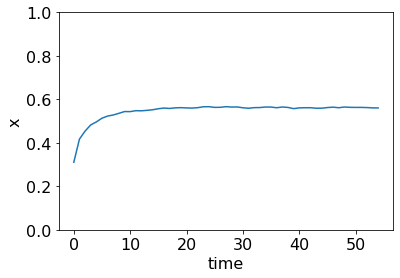

In [23]:
def f(x, C):
    """
    Conformity response function. 
    This is written such that x (average neighbor opinion) and C (alpha values) can be arrays
    """  
    lowbranch = (2*x)**C/2
    highbranch =  1 - (2*(1-x))**C/2
    y = (x>=0)*(x<=0.5)*lowbranch + (x>0.5)*(x <=1)*highbranch
    
    return y


def _update_I_learner(A, n, m): 
    """
    update opinion matrix A as if everyone is an individual learner
    """
    
    A_i = copy.deepcopy(A)
    
    Dice = np.random.uniform(size = (n, n))
    
    idx0 = (A_i ==0 ) # get the index for where entries are 0
    idx1 = (A_i == 1) # 
    p_01 = m  # transition rate form opinion 0 to 1. 
    p_10 = 1.-m # transition rate from 1 to 0
    
    A_i[idx0 & (Dice < p_01)] = 1 # set those with value 0 to 1 with probability m. 
    A_i[idx1 & (Dice < p_10)] = 0
    
    return A_i


def _update_S_learner(A, C, n):
    """
    update opinion matrix A as if everyone is an social learner
    uses alpha matrix C to assign each individual an alpha parameter
    the grid has a period boundary condition
    """
    A_s = copy.deepcopy(A)
    
    # get the sum of neighbors by shifting matrix 4 directions and sum. 
    A_up = np.roll(A_s, -1, axis = 0) # rolls 1 up 
    A_down = np.roll(A_s, 1, axis = 0) # rolls 1 down
    A_left = np.roll(A_s, -1, axis = 1) # rolls 1 left 
    A_right = np.roll(A_s, 1, axis = 1) # rolls 1 right 
    
    neighborSum = (A_up + A_down + A_left +  A_right)

    idx0 = (A_s == 0 ) # get the index for where entries are 0
    idx1 = (A_s == 1 ) # get the index for where entries are 1
    
    p_01 = f(neighborSum/4, C) # transition probability from 0 to 1 
    p_10 = f(1- neighborSum/4, C) # transition probability form 1 to 0
    
   
    Dice = np.random.uniform(size = (n, n))
    
    A_s[idx0 & (Dice < p_01)] = 1 # opinon 0 transition to 1
    A_s[idx1 & (Dice < p_10)] = 0 # opinon 1 transition to 0
    
    return A_s
    

def update(A, B, m, n, C): 
    """
    Function that updates the belief matrix based on updating rules for 1 step
    Use matrix operation to update everyone at once
    A is belief matrix
    B is updating type matrix, 1 is individual learner, 0 is social learner
    C is a matrix of alpha parameters
    Here the capital lettered variables are matrices. 
    A and B both need to be n by n matrices. 
    """
    
    A_i = _update_I_learner(A, n, m) # update everyone as if they're an individual learner
    A_s = _update_S_learner(A, C, n) # update everyone as if they're an social learner
    
    # index the two outputs by learning type matrix B, and combine results
    newA = A_i*(B == 1) + A_s*(B == 0) 
    
    return newA

def initilize(n, s, opthreshold):
    """
    input size of matrix and output initial A (opinion) and B (update type) matrix. 
    opthreshold =  portion of starting opinon of 1 
    s = portion of social learners. 
    in matrix b, 1 = individual learner, 0 = social learner. 
    """
    
    A = (np.random.uniform(size = [n, n])< opthreshold)*1
    B = (np.random.uniform(size = [n, n])< (1-s))*1

    return A, B

def initializeLumpy(n, s, opthreshold, scale, alpha_mean, alpha_sd, opinion_lumpy=True, update_lumpy=True, alpha_hetero=True):
    """
    Lumpy version of initialize() using simplex noise
    Outputs: initial A (opinion), B (update type), and C (alpha parameter) matrices
    in matrix B, 1 = individual learner, 0 = social learner
    
    n = size of matrices
    s = portion of social learners
    opthreshold = portion of starting opinion of 1
    scale = lumpiness parameter. Small values lead to more separation between types.
        Appropriate values are between 0.005
    opinion_lumpy and/or update_lumpy can be set to 'False' to use a uniform distribution for that matrix
    """
    if scale < 0:
        raise ValueError('scale parameter should be greater than 0')
    if not alpha_hetero:
        alpha_sd = 0
        
    # seed values allow the function to use an arbitrary coordinate in the simplex noise plane
    seed_x = random.random()*1024
    seed_y = random.random()*1024
        
    if opinion_lumpy:
        A = np.array([[1 if ((noise.snoise2(seed_x+i*scale, seed_y+j*scale)+1)/2 < opthreshold) else 0 for i in range(n)] for j in range(n)])
    else:
        A = (np.random.uniform(size = [n, n])< opthreshold)*1
    if update_lumpy:
        B = np.array([[1 if ((noise.snoise2(i*scale,j*scale)+1)/2<(1-s)) else 0 for i in range(n)] for j in range(n)])
    else:
        B = (np.random.uniform(size = [n, n])< (1-s))*1
    
    C = np.random.normal(loc=alpha_mean, scale=alpha_sd, size=(n,n))
    
    return A, B, C

def checkConverge(xList, tol, window=None):
    """
    Series is determined to converge once the root mean square of deviations falls below a given threshold.
    Outputs: converge (Bool), xmean (Float), and xstd (Float).
    
    xList: sequential list to test for convergence
    tol: tolerence threshold
    
    (written because my_functions.ipynb is missing from github repository. Note that this criteria seems to be different than whatever was used initially.)
    """
    converge = 0
    xmean = 0
    xstd = 0
    if len(xList) > 1:
        xmean = stat.mean(xList)
        xstd = stat.stdev(xList)
        if window:
            xstd_w = stat.stdev(xList[-window:])
        else:
            xstd_w = xstd
        if xstd_w < tol:
            converge = 1
            
    return(converge, xmean, xstd)

def runSim(tmax, m, n, alpha_mean, alpha_sd, s, x0, convTol, plotHist = 0): 
    """
    Runs the simulation with input paras
    output a and t. 
    plotHist: option to plot out the history of x. 
    """
    # initialize A and B. 
    A, B, C = initializeLumpy(n, s, x0, scale, alpha_mean, alpha_sd, opinion_lumpy=False, update_lumpy=False)
    
    A_i = copy.deepcopy(A) # save a copy of initial opinion
    
    xList = []
    # set default values for output if the simulation did not converge. 
    flag = 0
    x = np.nan
    tCov = "inf" 
    
    # run simulation 
    for i in np.arange(tmax):
        A = update(A, B, m, n, C)
        xList.append(np.mean(A)) # list storing x over time. 
        converge, xmean,xstd= checkConverge(xList,tol = convTol, window=10)

        if converge == 1:
            tCov = i
            x =  xmean # portion of people with opinion 1 at convergence.  
            flag = 1 # a flag checking whether the code converged. 
            break
            
    if plotHist == 1: 
        plt.plot(xList)
        plt.ylim([0, 1])
        plt.xlabel("time")
        plt.ylabel("x")
               
    # output a dictionary saving the parameters and outputs. 
    return {"m":m, "s": s, "x": x, "tCov": tCov, "IC": x0, "flag": flag, "opinion_i": A_i, "opinion_f": A}
    
# System Parameters. 
n = 200 #there are n*n individuals.  
s = 0.5 # portion of individual learners
m = 0.55 # merit of idea 1
alpha_mean = 1.8
alpha_sd = 0.5
scale = 0.25

# --- Run 1 trial with Numerical parameters and plot trajectory ---- 
tmax= 2000
x0 = 0.1 # initial conditions
convTol =  0.0016 # tolerance for convergence 
       
# do test run for 1 set of parameters
out = runSim(tmax, m, n, alpha_mean, alpha_sd, s, x0, convTol, plotHist =1)


Text(0.5, 1.0, 'final')

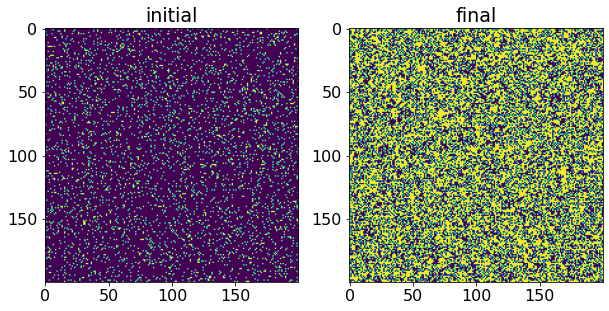

In [15]:
# Plot initial and final beliefs in spatial patterns
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title("initial")
plt.imshow(out["opinion_i"])

plt.subplot(1, 2, 2)
plt.imshow(out["opinion_f"])
plt.title("final")


### Loop through parameters

In [16]:
def run_multi_paras(sList, mList, x0List, alpha_mean, alpha_sd, n, tmax= 10000, convTol = 0.005): 
    """
    Run simulation with multiple parameters
    tmax : max simulation time
    convTol :convergence critieria
    """
    dicList = []
    for i, x0 in enumerate(x0List):
        x0 = x0List[i]
        for s in sList:
            if i == 0: 
                mOrder = mList
            elif i == 1:  # if trying to solve for upper branch, start with large m. 
                mOrder = np.flip(mList)
            for m in mOrder:
                out = runSim(tmax, m, n, alpha_mean, alpha_sd, s, x0, convTol)
                x0 = out["x"]
                dicList.append(out)
                if out["flag"] == 0:
                    print("warning: simulation did not converge")
    return pd.DataFrame(dicList)


# --- Specify parameters for simulation 
mList = np.linspace(0, 1, 30)
x0List = np.array([0.05, 0.95])

alpha_mean = 1.8
alpha_sd = 0.5
n = 200

# --- run the case of s = 0.5
sList1 = np.array([0.5])

res1 = run_multi_paras(sList1, mList, x0List, alpha_mean, alpha_sd, n, tmax= 10000, convTol = 0.002 )

/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/275958750.py:7: RuntimeWarning: divide by zero encountered in power
  lowbranch = (2*x)**C/2
/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/275958750.py:8: RuntimeWarning: divide by zero encountered in power
  highbranch =  1 - (2*(1-x))**C/2


In [18]:
# --- run the case of s = 0.95
sList2 = np.array([0.95])

res2 = run_multi_paras(sList2, mList, x0List, alpha_mean, alpha_sd, n, tmax= 10000, convTol = 0.002 )

/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/275958750.py:7: RuntimeWarning: divide by zero encountered in power
  lowbranch = (2*x)**C/2
/var/folders/5m/_3gkp3b95ql53ngyhjmy1wnw0000gn/T/ipykernel_78671/275958750.py:8: RuntimeWarning: divide by zero encountered in power
  highbranch =  1 - (2*(1-x))**C/2


Text(0, 0.5, 'x at steady state')

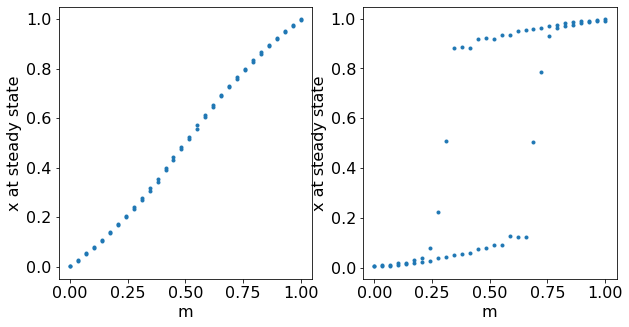

In [19]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)

plt.plot(res1.m, res1.x, ".")
plt.xlabel("m")
plt.ylabel("x at steady state")

plt.subplot(1, 2, 2)

plt.plot(res2.m, res2.x, ".")
plt.xlabel("m")
plt.ylabel("x at steady state")